In [1]:
import cv2
import csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '${:,.10f}'.format

from scipy.misc import imread, imresize
from sklearn.utils import shuffle
from os import listdir
from os.path import join
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [2]:
###### TRAINING CONSTANTS ######
SPLIT = 0.7
BATCH_SIZE = 40
EPOCHS = 10
VAL_SAMPLES = 1000
SAMPLES_PER_EPOCH = (20000//BATCH_SIZE)*BATCH_SIZE
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
############################

In [3]:
data = pd.read_csv('../../data/driving_log_clean.csv')

In [4]:
# Shuffling the data
data = data.sample(frac=1).reset_index(drop=True)

# Dropping some of the data to balance the dataset
bad = 0
for index1, row1 in data.iterrows():
	if row1['steering'] == 0:
		bad += 1
ind = []
for index, row in data.iterrows():
	if row['steering'] == 0:
		ind.append(index)
		bad -= 1
	if bad == 750:
		break
data = data.drop(data.index[ind]).reset_index(drop=True)

# Splitting the data: (See SPLIT under SOME CONSTANTS)
train_num = int(data.shape[0]*SPLIT)
training_data = data.loc[0:train_num-1]
validation_data = data.loc[train_num:]

In [5]:
print("Full Data Size: ", data.shape)
print("Split Rate: ", SPLIT)
print("Training Data Size: ", training_data.shape)
print("Validation Data Size: ", validation_data.shape)

Full Data Size:  (9456, 4)
Split Rate:  0.7
Training Data Size:  (6619, 4)
Validation Data Size:  (2837, 4)


In [6]:
data = None

In [7]:
def visualize_distribution(data):
    num_bins = 23
    avg_samples_per_bin = len(data)/num_bins
    hist, bins = np.histogram(data, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(data), np.max(data)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    plt.show()

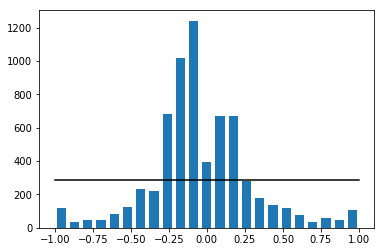

In [8]:
visualize_distribution(training_data['steering'])

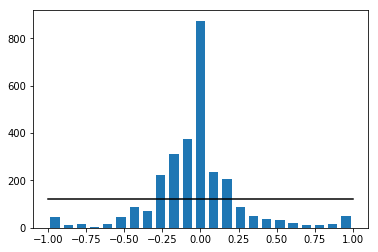

In [9]:
visualize_distribution(validation_data['steering'])

In [10]:
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def read(row, rand, is_Training, range_x=100, range_y=10):
    steering = row['steering']

    if is_Training and rand >= 0.6:
        img = imread(row['center'])
        img = preprocess(img)
        return img, steering

    camera = np.random.choice(['center', 'right', 'left'])

    if camera == 'Left':
        steering += 0.25
    elif camera == 'Right':
        steering -= 0.25

    img = imread(row[camera])
    img = preprocess(img)

    img, steering = random_flip(img, steering)
    img, steering = random_translate(img, steering, range_x, range_y)
    img = random_shadow(img)
    img = random_brightness(img)

    return img, steering

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [  8  17  14]
  [  8  17  14]
  [ 11  17  14]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 71 144 112]
  [ 75 144 112]
  [ 82 145 114]]

 ..., 
 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [179 148 128]
  [165 148 127]
  [152 150 128]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [181 149 127]
  [172 148 127]
  [159 149 128]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [170 150 127]
  [174 149 127]
  [172 150 127]]]
(66, 200, 3)
(66, 200, 3)
0.282436693082


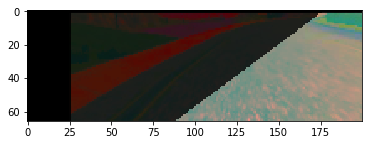

In [22]:
idx = np.random.randint(0, training_data.shape[0]-1)

row = training_data.iloc[idx]

x = np.zeros((66, 200, 3), dtype=np.float32)
y = np.zeros((), dtype=np.float32)
x, y = read(row, np.random.rand(), False)
print(x)
print(x.shape)
plt.imshow(x)
print(x.shape)
print(y)